<a href="https://colab.research.google.com/github/yfb2022/alphachodc/blob/main/SCOUTAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 원본 데이터프레임

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer
from sklearn.cluster import KMeans
import seaborn as sns
import re
# drive.mount('/content/drive')

In [2]:
df = pd.read_csv('/content/drive/My Drive/fm_final.csv', index_col = 0)

# 주발 피처
def compare_preferred_foot(df):
    left = df['Left Foot']
    right = df['Right Foot']
    df.drop(columns = ['Left Foot', 'Right Foot'], inplace = True)
    # 특정 발 능력치가 17 이상이면 양발 처리
    if left > right:
      if right >= 17:
        return 'both'
      else:
        return 'left'

    elif right > left:
      if left >= 17:
        return 'both'
      else:
        return 'right'

    else:
      return 'both'

df['preferred_foot'] = df.apply(compare_preferred_foot, axis=1)

In [3]:
# 분석용 데이터프레임 만들기
df2 = df.copy()
# df2 = df.drop(columns=['Date of birth','Salary'])
positions = df2['Position'].unique()
foot_dummies = pd.get_dummies(df2['preferred_foot'])
df2 = pd.concat([df2, foot_dummies], axis = 1)

# 골키퍼 데이터 프레임 분리
GK_df = df2.loc[df2['Position']=='GK'].reset_index(drop=True)
rest_df = df2.loc[df2['Position']!='GK'].reset_index(drop=True)

# 골키퍼 제외 나머지 포지션 인코딩
all_positions = []
for pos in positions:
  pieces = pos.split(',')
  all_positions.extend(pieces)

rest_positions = list(set(all_positions))
rest_positions.remove('GK')
rest_positions = sorted(rest_positions)

position_encoding = {}
for index, pos in zip(rest_df.index, rest_df['Position'].values):
  one_hot_encoding = [0]*13
  pieces = pos.split(',')
  for i, p in enumerate(rest_positions):
    if p in pieces:
      one_hot_encoding[i] = True

  position_encoding[index] = one_hot_encoding

pos_encodings = pd.DataFrame.from_dict(data = position_encoding, orient='index',
                                       columns = rest_positions)

rest_df = pd.concat([rest_df, pos_encodings], axis='columns')
GK_df['GK'] = 1

In [19]:
info_list = ['Name', 'Position', 'Age', 'Nationality', 'Club', 'Height', 'Weight',
             'ca', 'pa', 'World reputation', 'preferred_foot', 'Date of birth',
             'Salary','pics', 'video']

gk_info_list = ['Aerial Reach(GK)', 'Command Of Area(GK)', 'Communication(GK)',
                'Eccentricity(GK)', 'Handling(GK)', 'Kicking(GK)', 'One On Ones(GK)',
                'Reflexes(GK)', 'Rushing Out(GK)', 'Punching(GK)', 'Throwing(GK)']

rest_df_num = rest_df.drop(columns = info_list + gk_info_list)
GK_df_num = GK_df.drop(columns = info_list)

def scale_df(df):
  scaler = MinMaxScaler()
  rest_df_scaled_arr = scaler.fit_transform(df)
  rest_df_scaled = pd.DataFrame(rest_df_scaled_arr, columns= df.columns)
  return rest_df_scaled

rest_df_scl = scale_df(rest_df_num)
GK_df_scl = scale_df(GK_df_num)

rest_df_scl.insert(0, 'Name', rest_df['Name'])
GK_df_scl.insert(0, 'Name', GK_df['Name'])

In [42]:
def pca_dict(df, mode):
  df = df.iloc[:, 1:]
  dm_dict = {}
  if mode == 'rest':
    position_list = rest_positions
  elif mode == 'GK':
    position_list = ['GK']
  for i in position_list:
    pos_df = df[df[i]==1]
    pca = PCA(random_state=10)
    pca.fit(pos_df)
    total_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    dimension = np.argmax(total_explained_variance >= 0.95) + 1
    dm_dict[i] = dimension
    print(("{} Features: {}").format(i, dimension))
    print("{} Total Explained Variance: {}".format(i, total_explained_variance[dimension-1]))
  return dm_dict

def reduce_dim(df, dm_dict):
  tsne_dict = {}
  for i in dm_dict:
    pca = PCA(n_components = dm_dict[i])
    pos_df = df[df[i]==1]
    X_pca = pca.fit_transform(pos_df)
    tsne = TSNE(n_components = 2,
               verbose = 1,
               perplexity = 30,
               random_state = 10)
    X_tsne = tsne.fit_transform(X_pca)
    tsne_dict[i] = X_tsne
  return tsne_dict

rest_dm_dict = pca_dict(rest_df_scl.iloc[:,1:], 'rest')
GK_dm_dict = pca_dict(GK_df_scl.iloc[:,1:], 'GK')

rest_tsne = reduce_dim(rest_df_scl.iloc[:,1:], rest_dm_dict)
GK_tsne = reduce_dim(GK_df_scl.iloc[:,1:], GK_dm_dict)

AMC Features: 33
AMC Total Explained Variance: 0.953607445103605
AML Features: 33
AML Total Explained Variance: 0.9512614682528365
AMR Features: 32
AMR Total Explained Variance: 0.9507187685999445
DC Features: 32
DC Total Explained Variance: 0.9510521857312598
DL Features: 32
DL Total Explained Variance: 0.9537438469136248
DM Features: 30
DM Total Explained Variance: 0.9511315953498954
DR Features: 34
DR Total Explained Variance: 0.9531312123986985
MC Features: 32
MC Total Explained Variance: 0.9527580312767389
ML Features: 21
ML Total Explained Variance: 0.954463441513799
MR Features: 25
MR Total Explained Variance: 0.9529180896432013
ST Features: 33
ST Total Explained Variance: 0.9501663661043662
WBL Features: 27
WBL Total Explained Variance: 0.9519830197964415
WBR Features: 28
WBR Total Explained Variance: 0.9502366606203049
GK Features: 41
GK Total Explained Variance: 0.9522300865531198
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 819 samples in 0.001s...
[t-SNE] Compu

# Elbow Method

In [37]:
rest_tsne.keys()

dict_keys(['AMC', 'AML', 'AMR', 'DC', 'DL', 'DM', 'DR', 'MC', 'ML', 'MR', 'ST', 'WBL', 'WBR'])

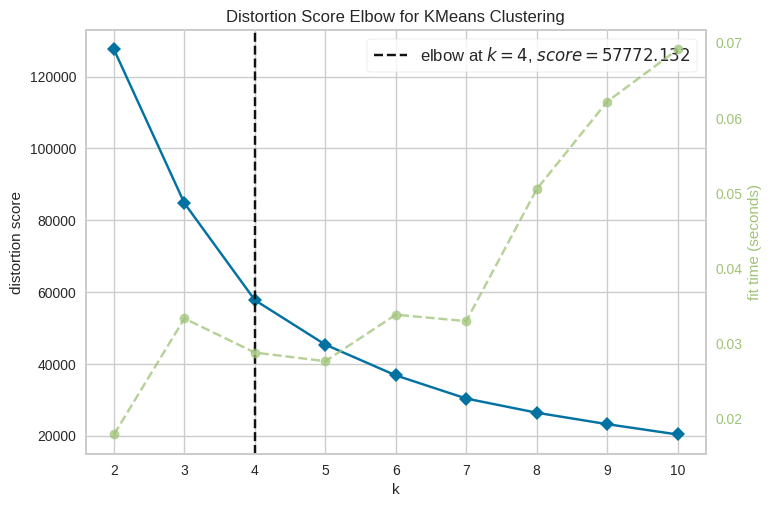

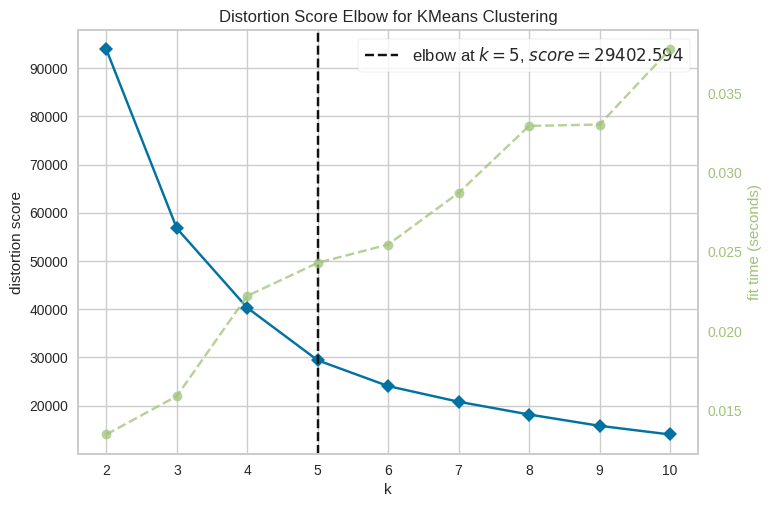

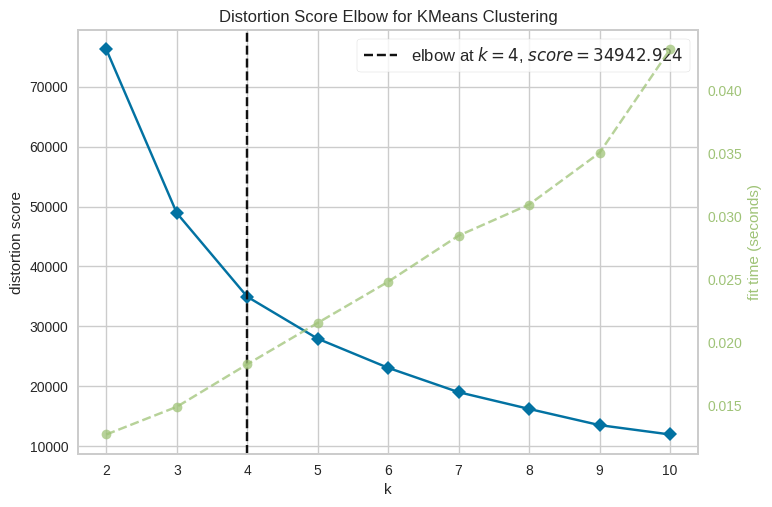

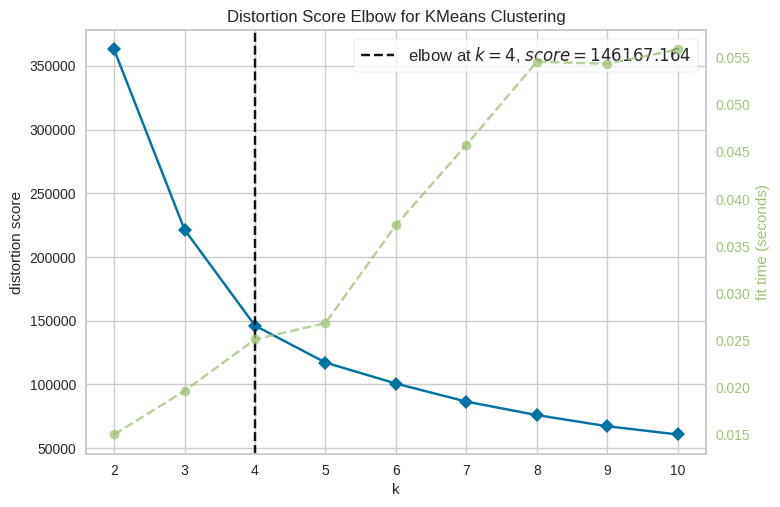

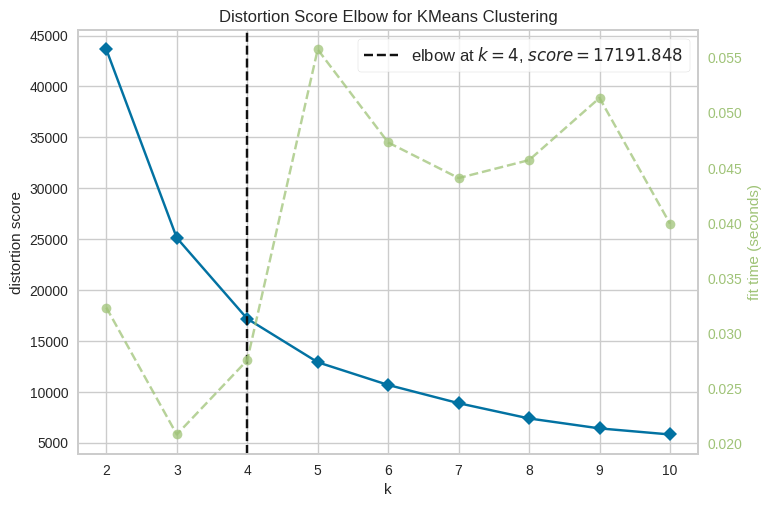

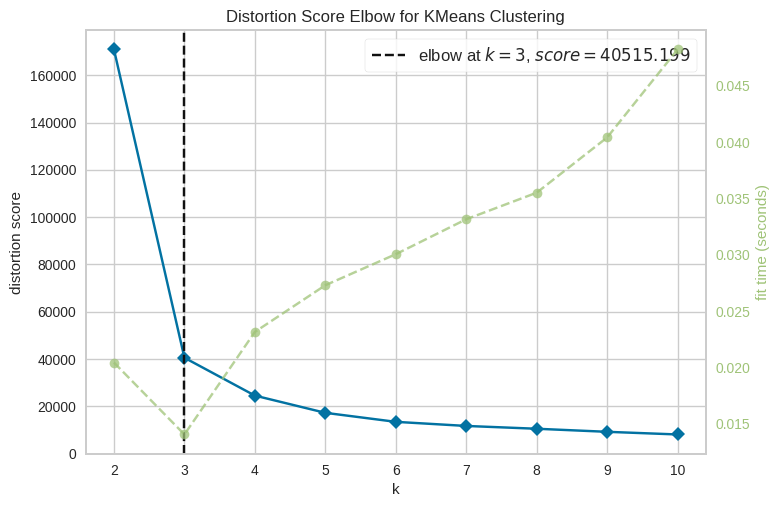

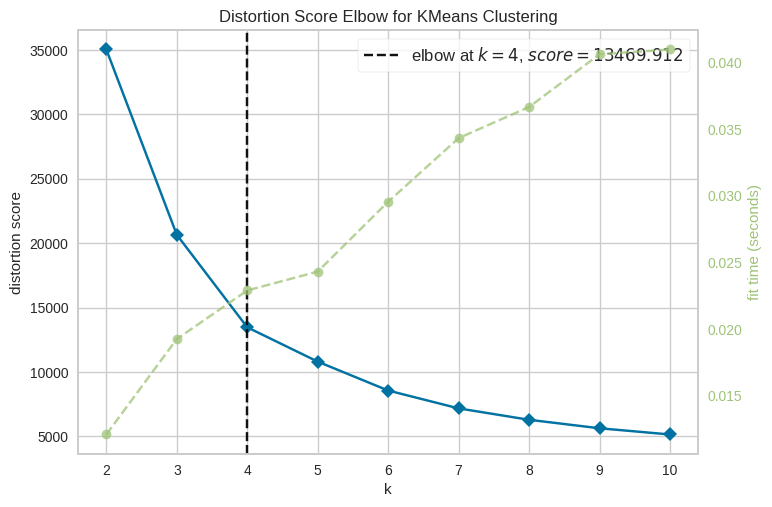

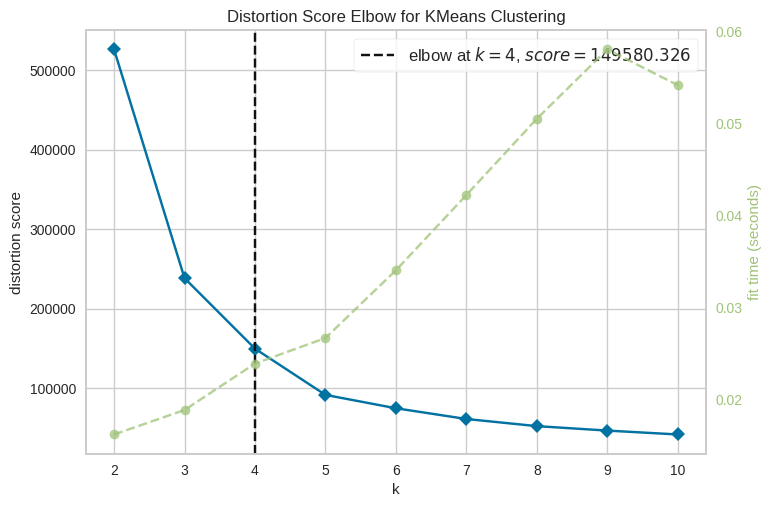

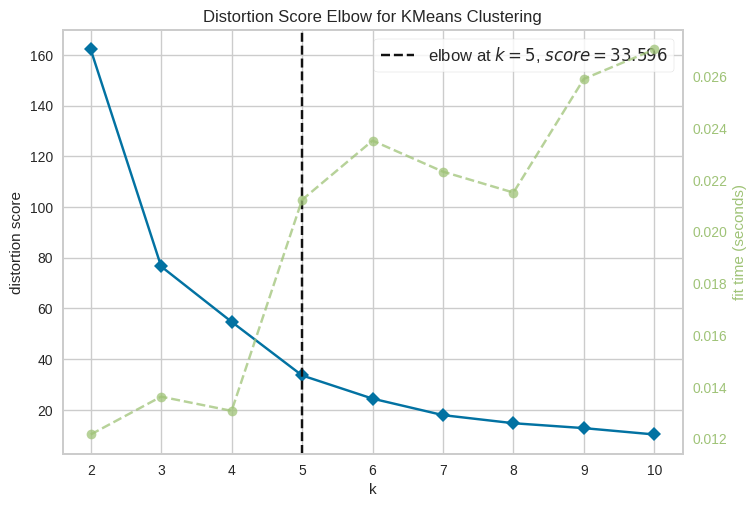

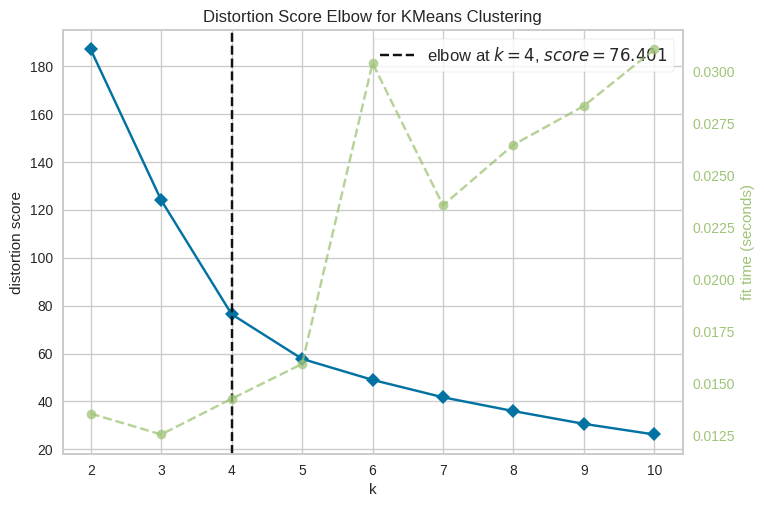

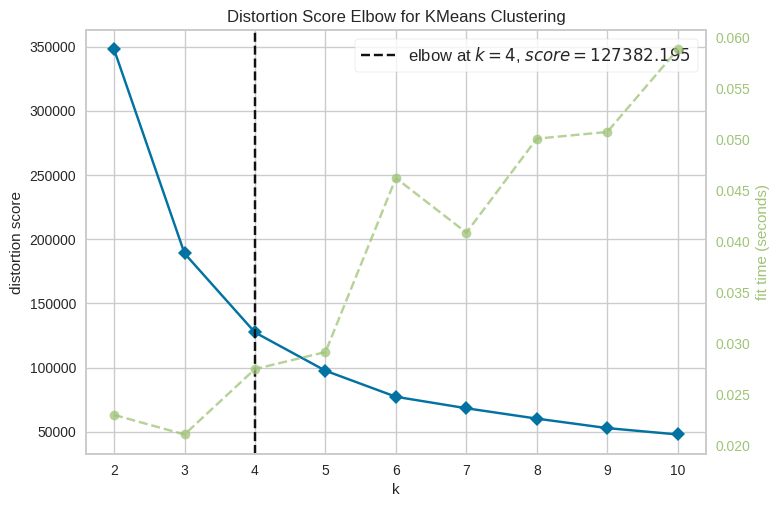

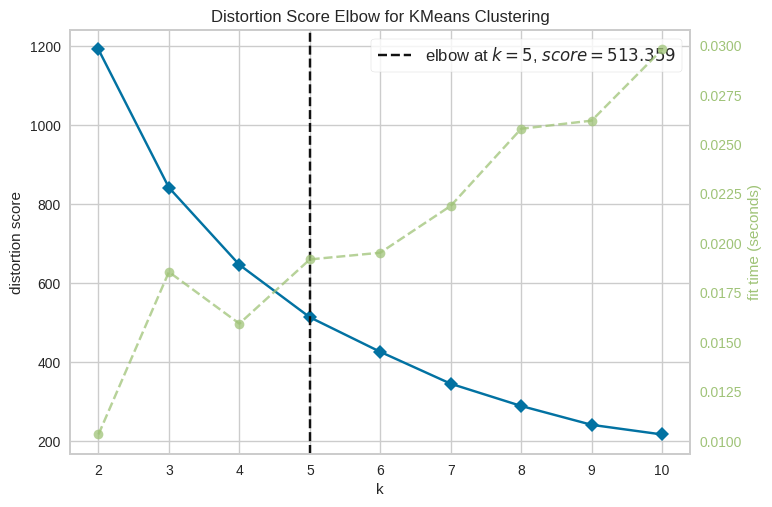

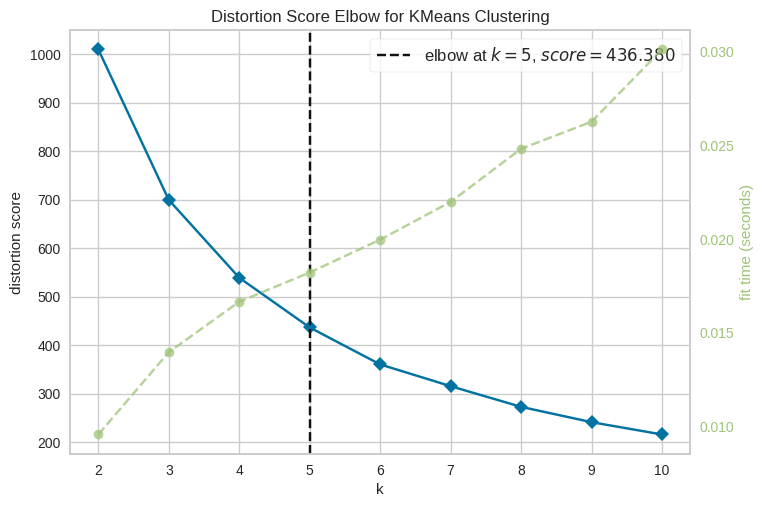

In [43]:
for i in rest_tsne:
  kelbow_visualizer(KMeans(random_state=10, n_init=10), rest_tsne[i], k=(2, 11))

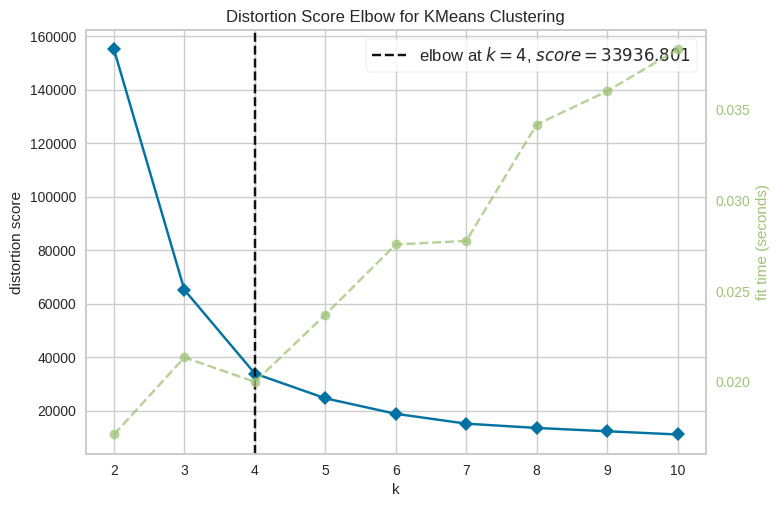

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, n_init=10, random_state=10),
                 k=(2, 11))

In [45]:
kelbow_visualizer(KMeans(random_state=10, n_init=10), GK_tsne['GK'], k=(2, 11))

# Silhouette Method

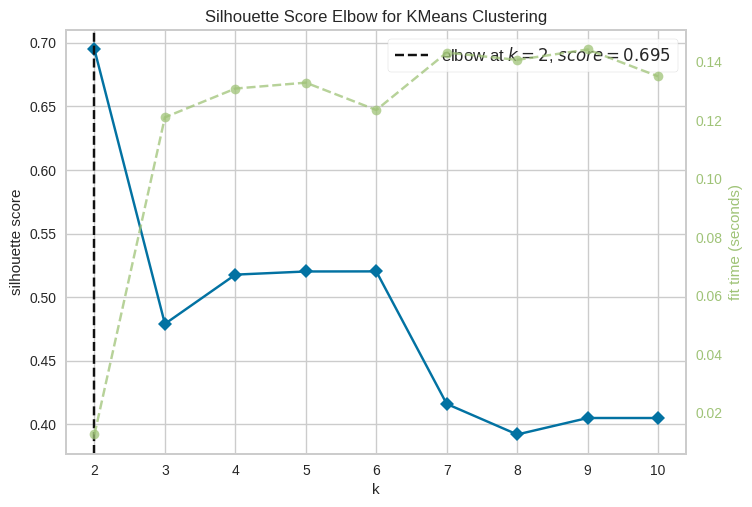

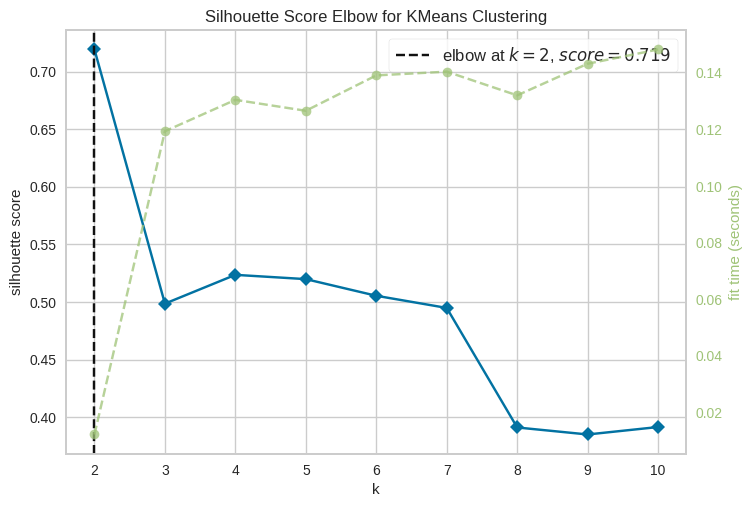

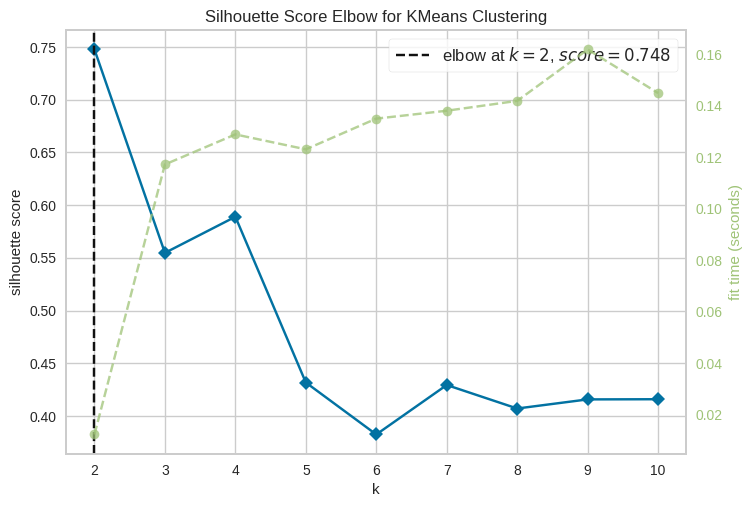

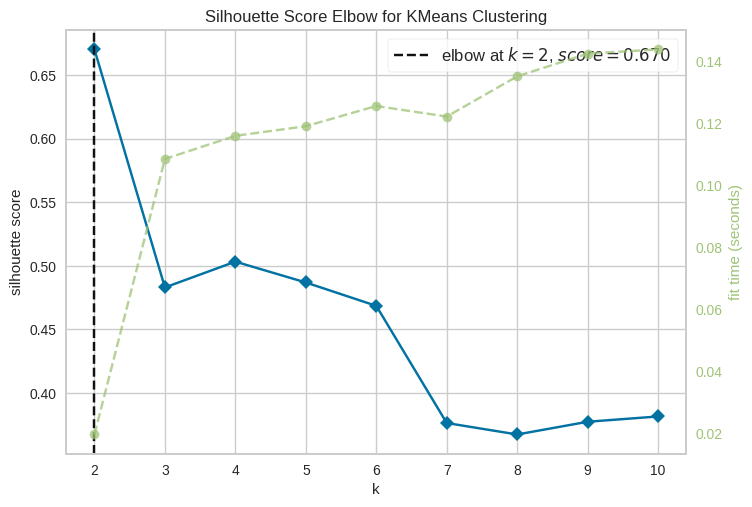

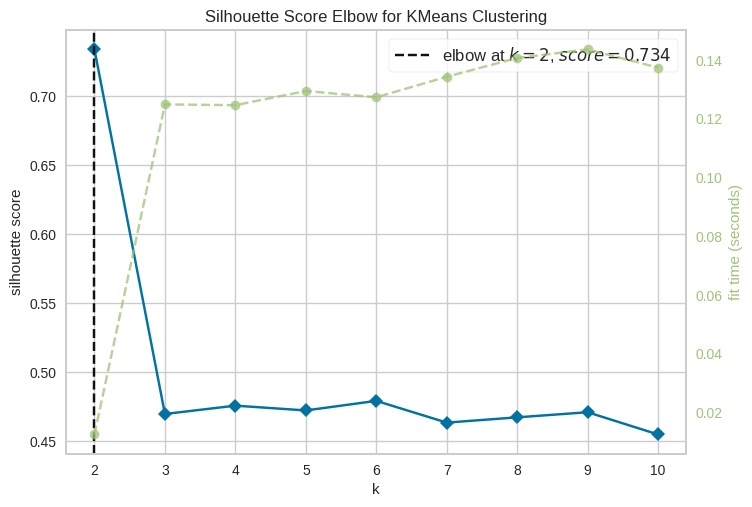

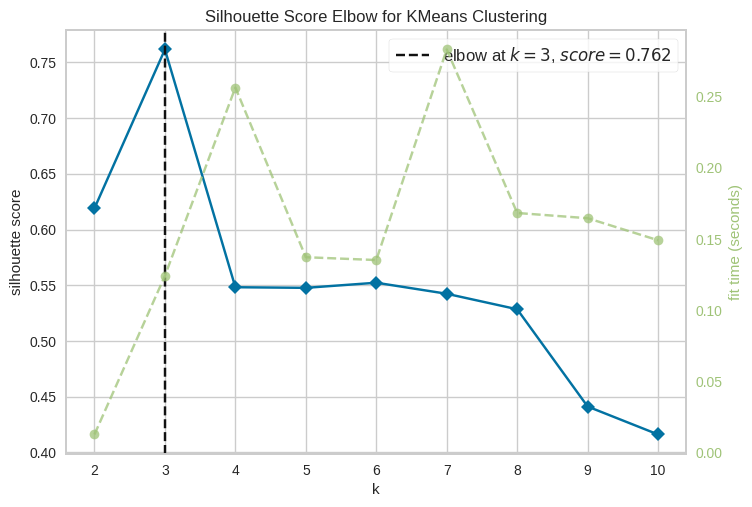

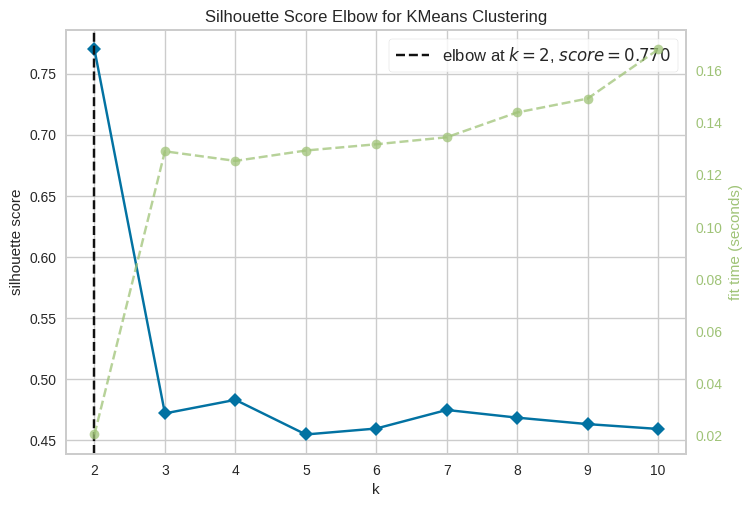

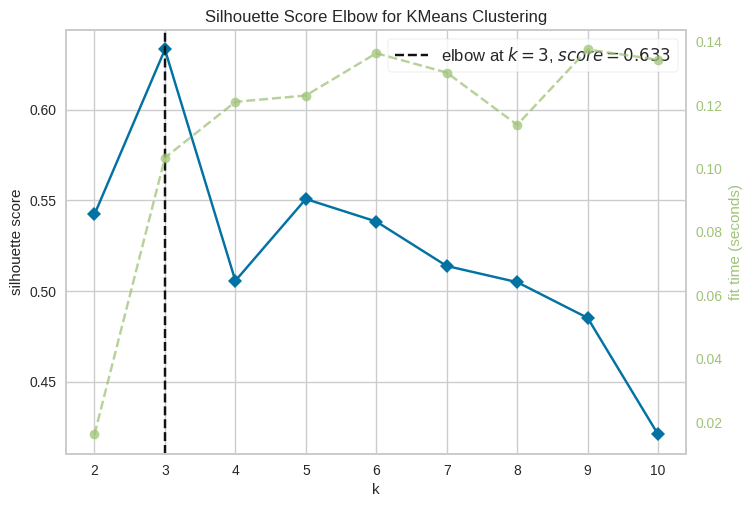

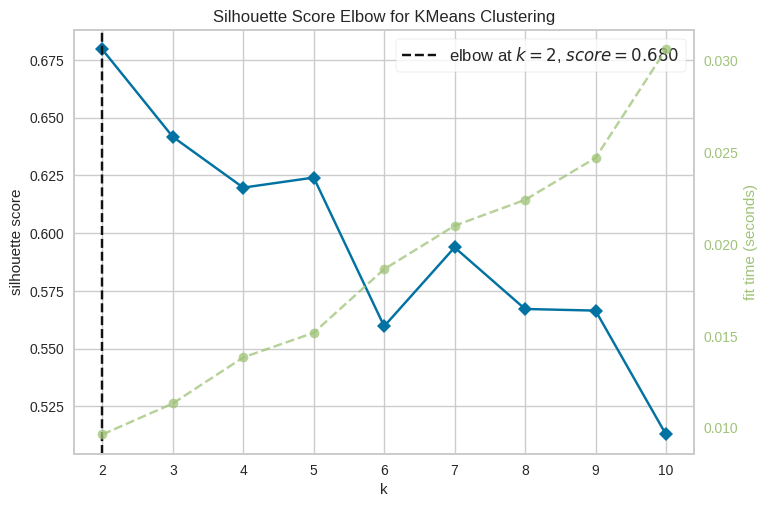

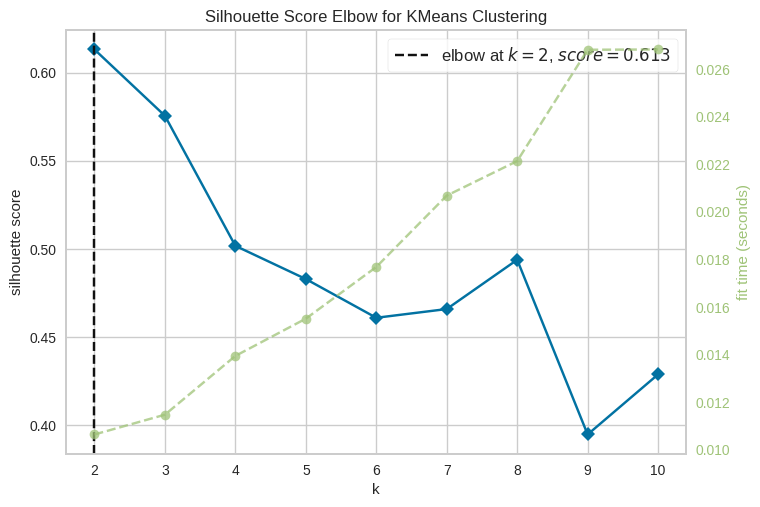

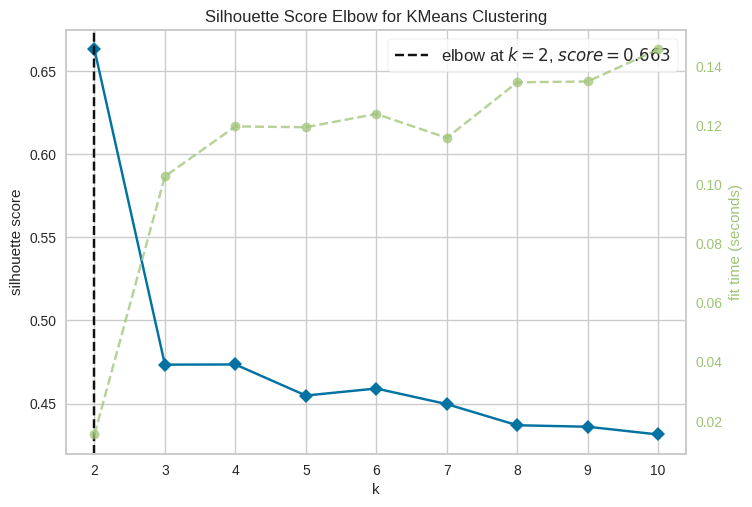

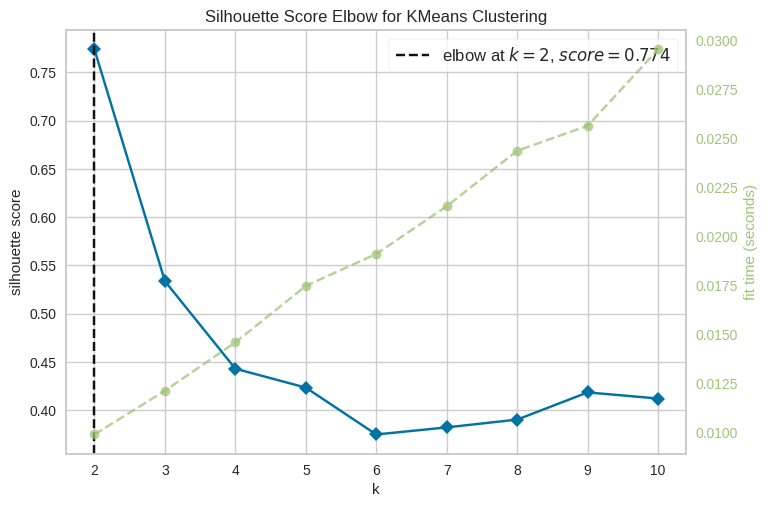

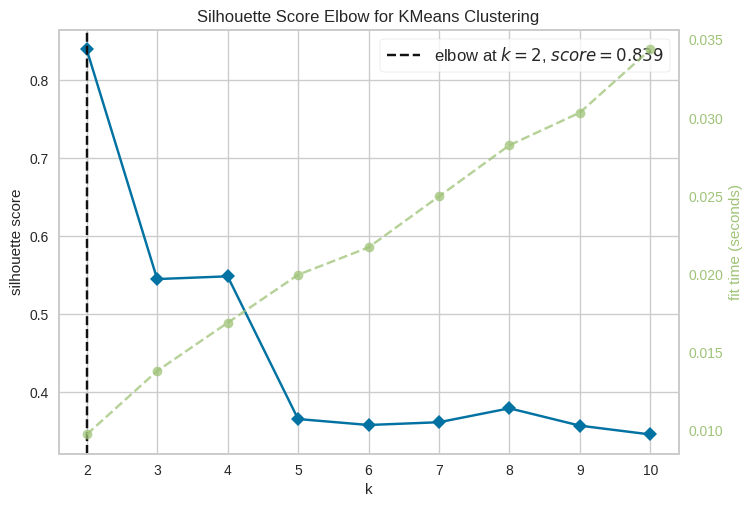

In [46]:
for i in rest_tsne:
  kelbow_visualizer(KMeans(random_state=10, n_init=10), rest_tsne[i], k=(2, 11), metric = 'silhouette')

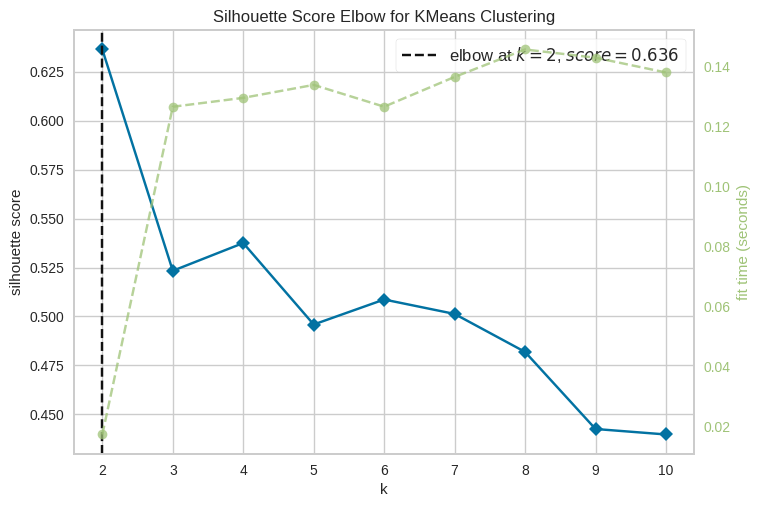

KElbowVisualizer(ax=<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=10, n_init=10, random_state=10),
                 k=(2, 11), metric='silhouette')

In [47]:
kelbow_visualizer(KMeans(random_state=10, n_init=10), GK_tsne['GK'], k=(2, 11), metric = 'silhouette')

In [48]:
rest_tsne.keys()

dict_keys(['AMC', 'AML', 'AMR', 'DC', 'DL', 'DM', 'DR', 'MC', 'ML', 'MR', 'ST', 'WBL', 'WBR'])

# Silhouette Score

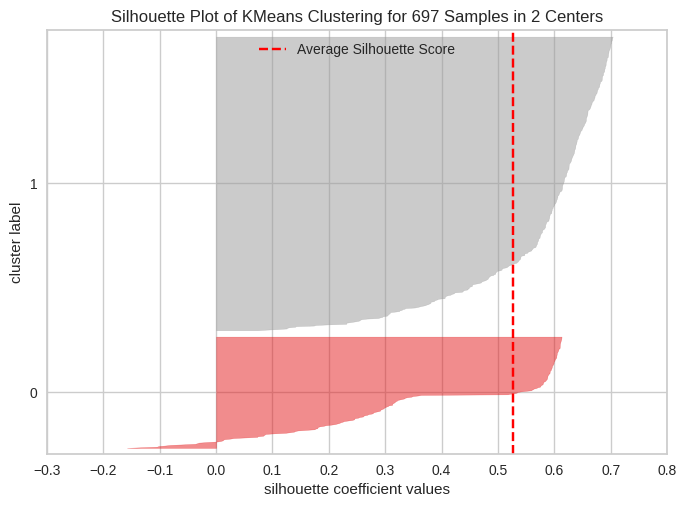

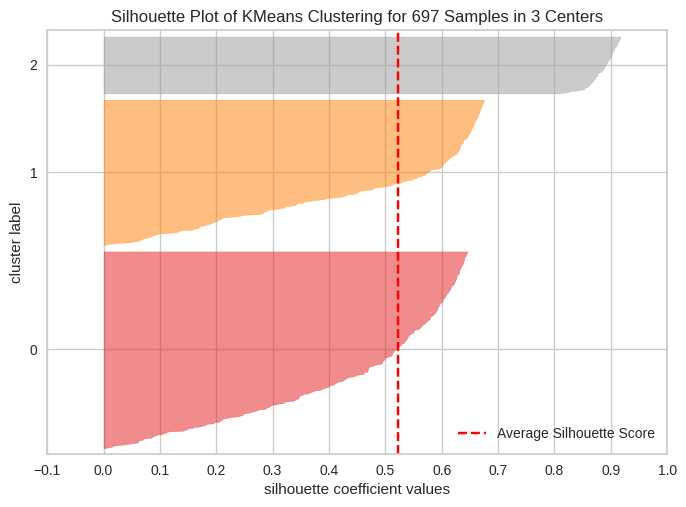

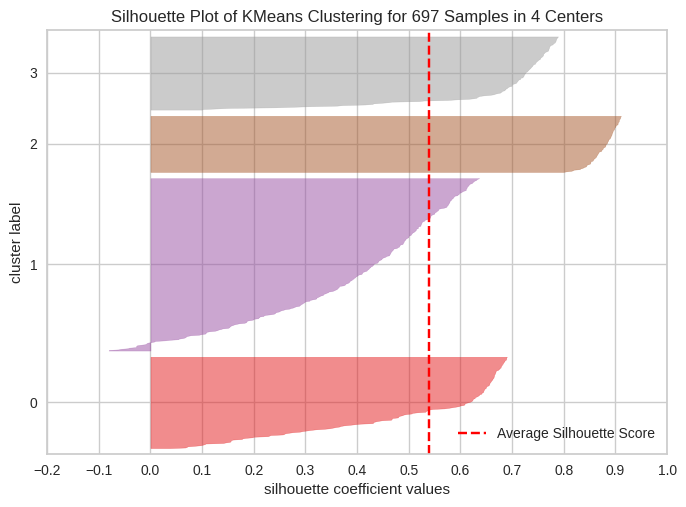

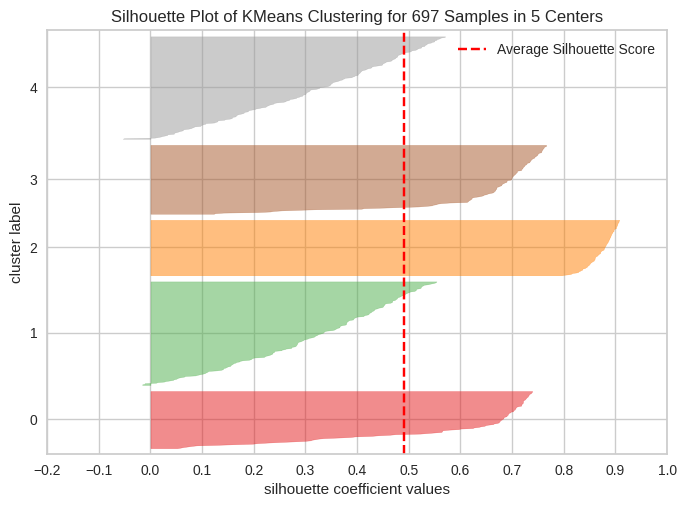

In [62]:
for k in (2, 3, 4, 5):
  silhouette_visualizer(KMeans(n_clusters= k, random_state=10), GK_tsne['GK'])

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


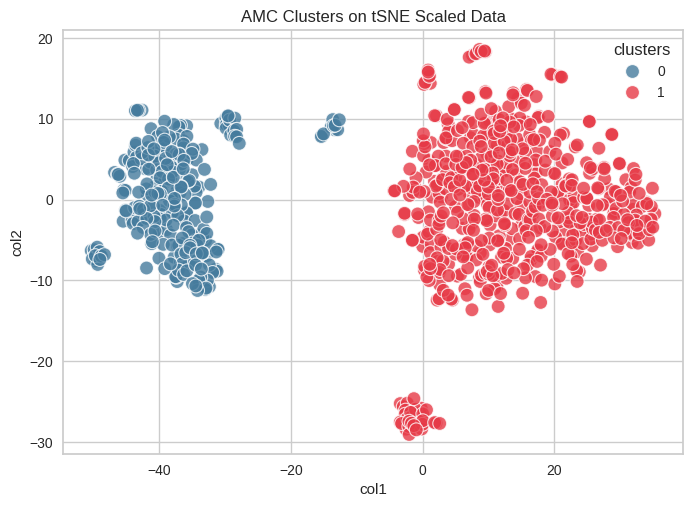

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


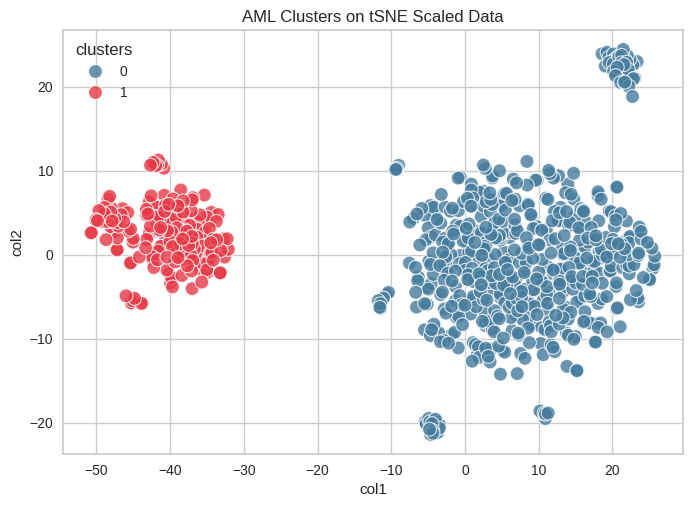

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


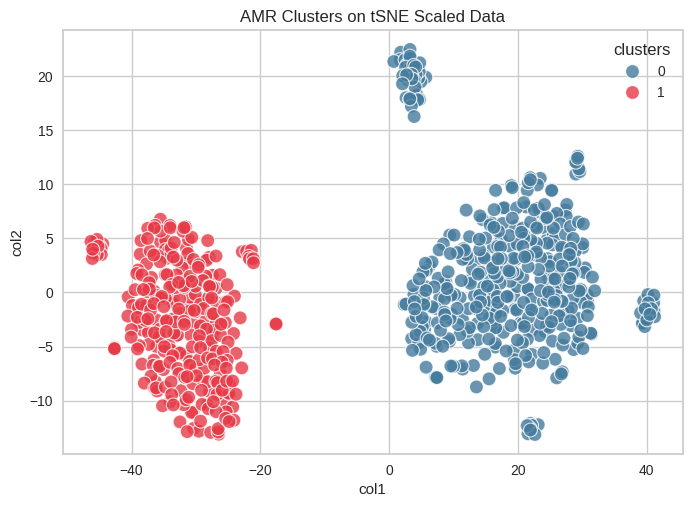

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


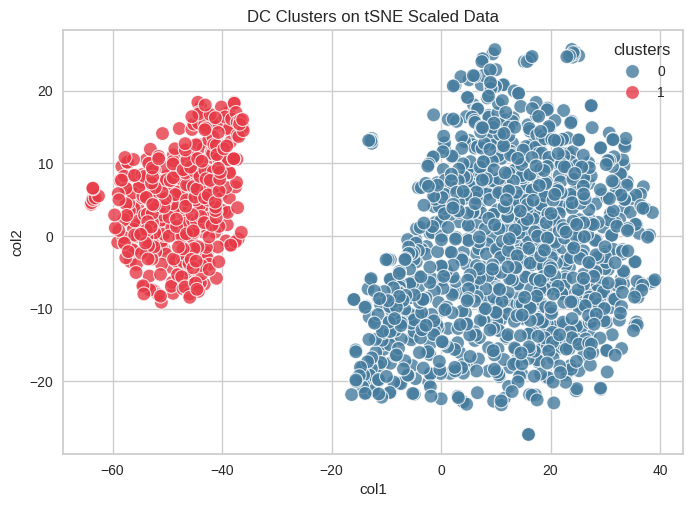

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


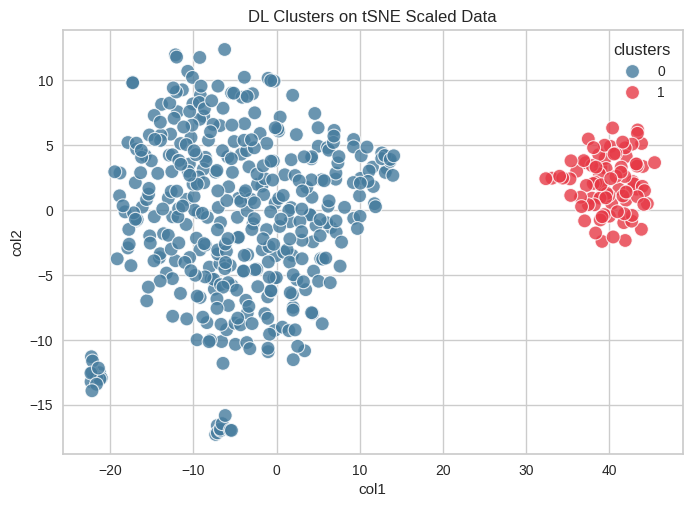

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


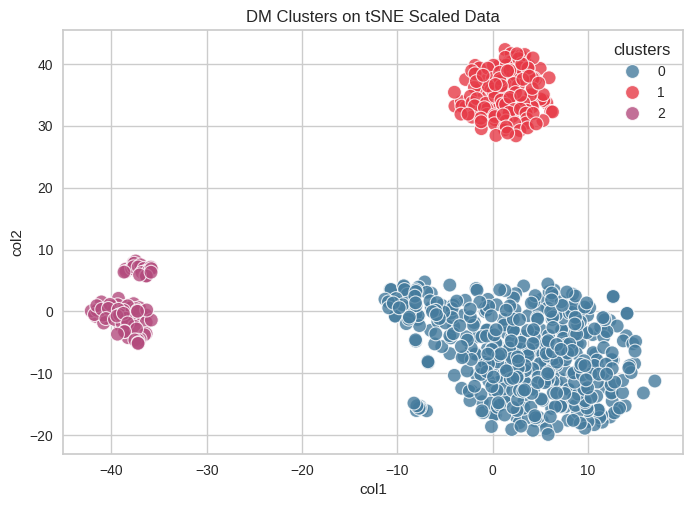

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


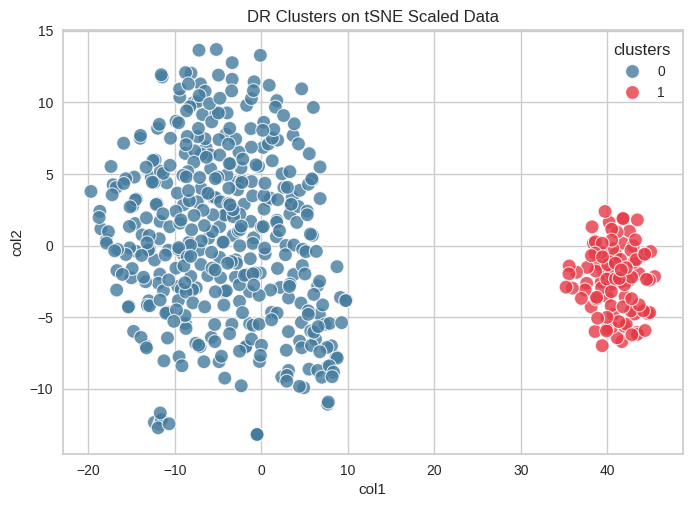

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


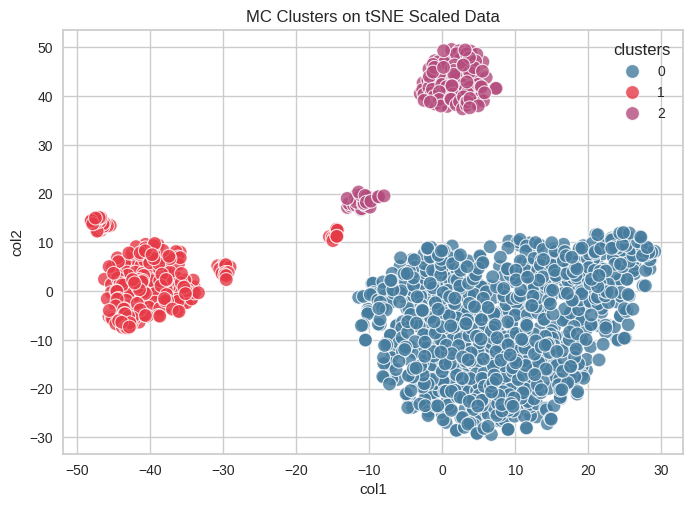

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


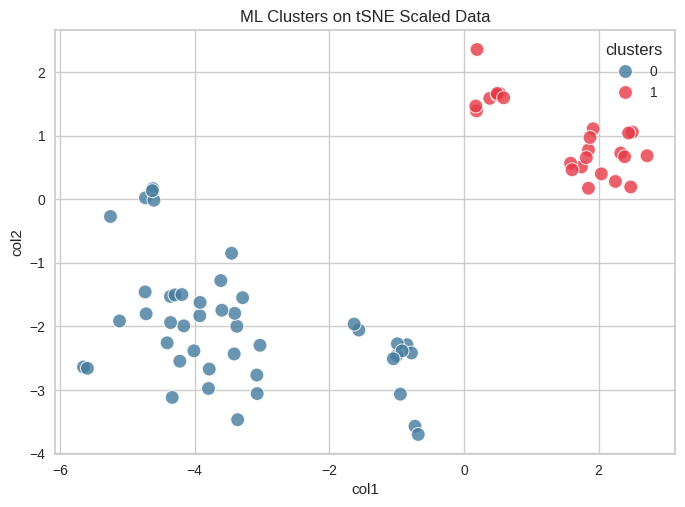

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


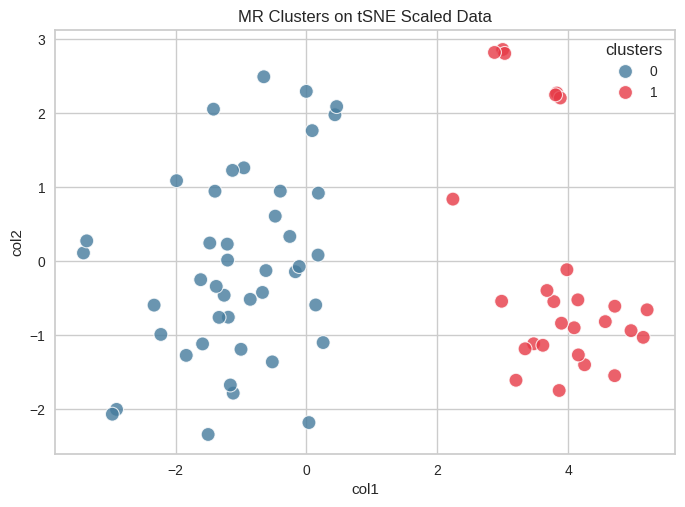

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


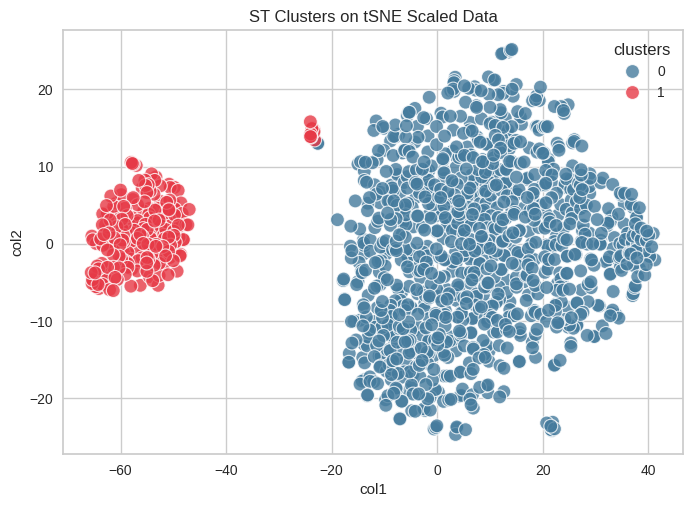

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


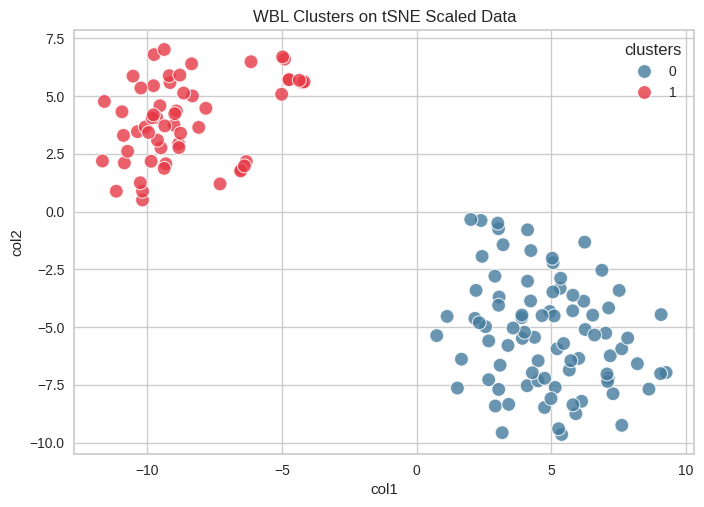

<ipython-input-67-bdb462b724ca>:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


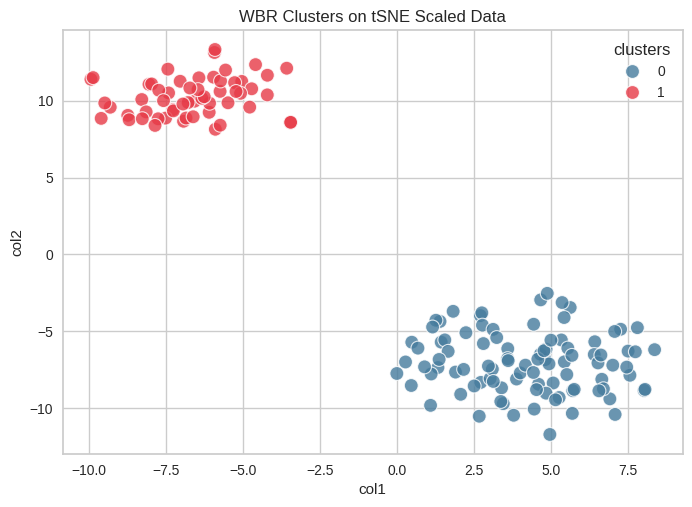

In [67]:
custom_palette = ["#457b9d", "#e63946", "#B34B7D", "#4D8C60"]

cluster_dict = {'AMC': 2, 'AML': 2, 'AMR': 2, 'DC': 2, 'DL': 2, 'DM': 3, 'DR': 2,
                'MC': 3, 'ML': 2, 'MR': 2, 'ST': 2, 'WBL': 2, 'WBR': 2}

rest_df_scl['cluster'] = ''
rest_df['cluster'] = ''

for key, value in cluster_dict.items():
  kmeans = KMeans(n_clusters=value, n_init=10, random_state=14)
  kmeans.fit(rest_tsne[key])
  cluster_df = pd.DataFrame(rest_tsne[key], columns=['col1', 'col2'])
  cluster_df['clusters'] = kmeans.labels_
  cluster_labels = [f'{key}_{label}' for label in kmeans.labels_]
  rest_df_scl.loc[rest_df_scl[key] == 1, 'cluster'] += cluster_labels
  rest_df.loc[rest_df[key] == 1, 'cluster'] += cluster_labels

  plt.title("{} Clusters on tSNE Scaled Data".format(key))

  sns.scatterplot(
    data=cluster_df,
    x='col1',
    y='col2',
    hue='clusters',
    palette=custom_palette,
    s=100,
    alpha=0.8
  )

  plt.show()

<ipython-input-72-abe174f9ae36>:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


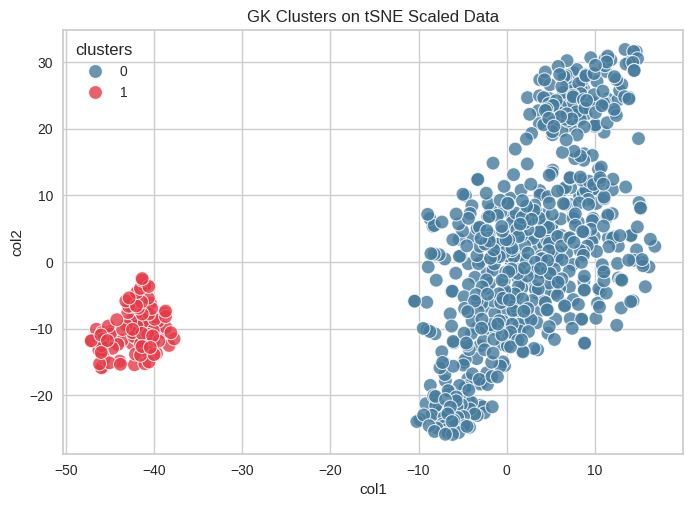

In [72]:
GK_df_scl['cluster'] = ''
GK_df['cluster'] = ''

# for i in range(2,5): # 3
kmeans = KMeans(n_clusters= 2, n_init=10, random_state=14)
kmeans.fit(GK_tsne['GK'])
gk_cluster_df = pd.DataFrame(GK_tsne['GK'], columns=['col1', 'col2'])
gk_cluster_df['clusters'] = kmeans.labels_
gk_cluster_labels = [f'GK_{label}' for label in kmeans.labels_]
GK_df_scl['cluster'] = gk_cluster_labels
GK_df['cluster'] = gk_cluster_labels

plt.title("GK Clusters on tSNE Scaled Data")

sns.scatterplot(
    data=gk_cluster_df,
    x='col1',
    y='col2',
    hue='clusters',
    palette=custom_palette,
    s=100,
    alpha=0.8
  )

plt.show()

In [77]:
rest_df_scl['cluster'] = rest_df_scl['cluster'].apply(lambda x: re.findall(r'[A-Za-z]+_\d+', x))
GK_df_scl['cluster'] = GK_df_scl['cluster'].apply(lambda x: re.findall(r'[A-Za-z]+_\d+', x))
rest_df['cluster'] = rest_df['cluster'].apply(lambda x: re.findall(r'[A-Za-z]+_\d+', x))
GK_df['cluster'] = GK_df['cluster'].apply(lambda x: re.findall(r'[A-Za-z]+_\d+', x))

In [81]:
dataframes = {
    "rest_df_scl": rest_df_scl,
    "GK_df_scl": GK_df_scl,
    "rest_df": rest_df,
    "GK_df": GK_df
}

for name, df in dataframes.items():
    df.to_csv(f'/content/drive/MyDrive/dataset/{name}.csv', index=False)

# STREAMLIT WEB SERVING

In [ ]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.8 MB/s eta 0:00:00


In [ ]:
!pip install flagpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 8.6 MB/s eta 0:00:00


# START FROM HERE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%writefile app.py
import pandas as pd
import numpy as np
import streamlit as st
import re
import os
import base64
import time
from PIL import Image
from ast import literal_eval
import plotly.graph_objects as go
import flagpy as fp

page_bg_img = """
<style>
[data-testid="stAppViewContainer"]{
  background-image: url("https://images.unsplash.com/photo-1431324155629-1a6deb1dec8d?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1740&q=80");
  background-size: cover;
  }
[data-testid="stHeader"]{
  background-color: rgba(0,0,0,0);
  }
[data-testid="stToolbar"]{
  right: 2rem;
  background-color: #42F328;
  }
</style>
"""

st.markdown(page_bg_img, unsafe_allow_html = True)
st.markdown("""
<style>
[data-testid="stSidebar"]{
  background-color: #0F0F0F;
  color: #42F328;
  }
[data-testid="stMarkdownContainer"] > div > h2{
  color: white;
  }
[data-testid="stMarkdownContainer"]> p{
  color: white;
  }
</style>
""", unsafe_allow_html=True)

st.markdown("""
<style>
[data-testid="stMetricValue"]{
  color: #42F328;
  font-size: 40px;
  }
[data-testid="stMarkdownContainer"] > div > h3 > div > span{
  color: white;
}
</style>
""", unsafe_allow_html = True)

rest_df_dt= pd.read_csv('/content/drive/MyDrive/rest_df_dt.csv')
rest_df=pd.read_csv('/content/drive/MyDrive/rest_df.csv')
GK_df_dt = pd.read_csv('/content/drive/MyDrive/GK_df_dt.csv',index_col=0)
GK_df = pd.read_csv('/content/drive/MyDrive/GK_df.csv',index_col=0)

rest_df.loc[rest_df['pics'] == 'None', 'pics'] = 'https://img.a.transfermarkt.technology/portrait/header/default.jpg?lm=1'
GK_df.loc[GK_df['pics'] == 'None', 'pics'] = 'https://img.a.transfermarkt.technology/portrait/header/default.jpg?lm=1'

rest_df_dt['cluster']=rest_df_dt['cluster'].apply(lambda x: literal_eval(x))
rest_df['cluster']=rest_df['cluster'].apply(lambda x: literal_eval(x))
GK_df_dt['cluster'] = GK_df_dt['cluster'].apply(lambda x: literal_eval(x))
GK_df['cluster'] = GK_df['cluster'].apply(lambda x: literal_eval(x))


def cosine_similarity(vec1, vec2):
  a = np.array(vec1).ravel()
  b = np.array(vec2).ravel()
  denom = np.sqrt(np.sum(np.square(vec1))) * np.sqrt(np.sum(np.square(vec2)))
  return np.dot(a,b) / denom

def similar_players(index, threshold):
  similarity_scores = {}
  for k, v in vectors.items():
    similarity_scores[k] = cosine_similarity(vectors[index], v)
  similarity_scores = {key: value for key, value in similarity_scores.items() if value >= threshold}

  return similarity_scores

st.sidebar.header("당신의 유망주를 찾아드립니다")
name_list=list(rest_df['Name'].values)+list(GK_df['Name'].values)
name_list.append('')
player_input= st.sidebar.selectbox('게임 내 좋아하는 선수를 입력하세요: ',name_list,index=7755)#
threshold = st.sidebar.number_input('최소 유사도를 입력해주세요 (90, 93, 95): ',0,99)
fm_image=Image.open('/content/drive/MyDrive/scouter_image2.png')
st.sidebar.image(fm_image)

if player_input in rest_df['Name'].values:
  temp_df = rest_df
  temp_df_dt = rest_df_dt
  categories = ['Defending','Physical','Speed', 'Vision', 'Attacking','Technique','Aerial','Mental']

  def skill_cal(youth1):
    defending = youth1['Tackling']*0.5 + youth1['Marking']*0.25 + youth1['Positioning']*0.25
    physical = youth1['Strength']*0.25 + youth1['Stamina']*0.25 + youth1['Balance']*0.25 + youth1['Agility']*0.25
    speed = youth1['Acceleration']*0.5 + youth1['Pace']*0.5
    vision = youth1['Vision']*0.33 + youth1['Flair']*0.33 + youth1['Passing']*0.34
    attacking = youth1['Finishing']*0.34 + youth1['Off The Ball']*0.33 + youth1['Composure']*0.33
    technique = youth1['Technique']*0.34 + youth1['First Touch']*0.33 + youth1['Dribbling']*0.33
    aerial = youth1['Heading']*0.5 + youth1['Jumping Reach']*0.5
    mental = (youth1['Determination'] + youth1['Decision'] + youth1['Anticipation']+ youth1['Teamwork'] + youth1['Bravery'] + youth1['Concentration'])*0.166
    return [defending, physical, speed, vision, attacking, technique, aerial, mental]

elif player_input in GK_df['Name'].values:
  temp_df = GK_df
  temp_df_dt = GK_df_dt
  categories = ['Distribution','Eccentricity','Mental','Shot Stopping','Physical','Speed','Aerial','Communication']

  def skill_cal(youth1):
    distribution = youth1['Passing']*0.25 + youth1['Vision']*0.25 + youth1['Kicking(GK)']*0.25 + youth1['Throwing(GK)']*0.25
    eccentricity = youth1['Aggression']*0.2 + youth1['Eccentricity(GK)']*0.8
    mental = (youth1['Anticipation'] + youth1['Bravery'] + youth1['Concentration'] +
    youth1['Determination'] + youth1['Teamwork'] + youth1['Decision']) *0.166
    shot_stopping = youth1['Reflexes(GK)']*0.3 + youth1['One On Ones(GK)']*0.3 + youth1['Handling(GK)']*0.2 + youth1['Punching(GK)']*0.2
    physical = youth1['Agility']*0.3 + youth1['Balance']*0.2 + youth1['Natural Fitness']*0.2 + youth1['Work Rate']*0.2 + youth1['Stamina']*0.1
    speed = youth1['Rushing Out(GK)']*0.6 + youth1['Pace']*0.4
    aerial = youth1['Aerial Reach(GK)']*0.8 + youth1['Jumping Reach']*0.2
    communication =  youth1['Communication(GK)']*0.7 + youth1['Command Of Area(GK)']*0.3
    return [distribution, eccentricity, mental, shot_stopping, physical, speed, aerial, communication]

else:
  raise 'Error'

# 선수에 해당하는 클러스터
cluster = temp_df_dt[temp_df_dt['Name'] == player_input]['cluster']
input_df = temp_df[temp_df['Name'] == player_input]
# 선수 클러스터에 해당하는 모든 선수 (scaled)
cl_df = temp_df_dt[temp_df_dt['cluster'].apply(lambda x: any(k in x for k in cluster.values[0]))]
# 선수 클러스터에 해당하는 모든 선수 (original)
original_df = temp_df[temp_df['cluster'].apply(lambda x: any(k in x for k in cluster.values[0]))]

# 필터된 데이터프레임 인덱스 초기화
cl_df = cl_df.reset_index(drop=True)
original_df = original_df.reset_index(drop=True)

# 플레이어 이름
player = cl_df[cl_df['Name'] == player_input].index[0]

# 선수 능력치 배열
cl_X = cl_df.iloc[:,1:-1].values

# 선수 이름 배열
cl_Y = cl_df.iloc[:,0].values

# 코사인 유사도 (threshold input으로 구현해야 됨)
vectors = {}
for i, x in enumerate(cl_X):
  vectors[i] = x.tolist()

threshold = threshold/100

if (threshold!=0):
  top_sim_players = similar_players(player, threshold)
  top_players = {}
  # 선수의 코사인 유사도를 기존 선수 데이터 딕셔너리에 삽입
  for index, similarity in top_sim_players.items():
      info = list(original_df.iloc[index].values)
      info.insert(1, similarity)
      top_players[index] = info
  lst = list(original_df.columns)
  lst.insert(1,'similarity')

  # 유사 선수 데이터 프레임 만들기
  output = pd.DataFrame.from_dict(data= top_players, orient = 'index', columns = lst)
  # 연령 제한 / 능력치 제한
  filtered_output = output[(output['Age'] <= 21) & (output['pa'] >= 130)].iloc[:,0:53]

  # 유사도 중복 기준 (소수 둘째까지 같으면 반올림)
  def similarity_key(similarity):
      return round(similarity, 2)

  sim = filtered_output['similarity'].apply(similarity_key)

  filtered_output.insert(1, 'sim', sim)
  st.write('가장 플레이스타일이 비슷한 유망주는....')

  # 유사도가 중복된다면 잠재 능력치 기준으로 정렬
  filtered_output = filtered_output.sort_values(by=['sim', 'pa'], ascending=False)
  first_similar_player=filtered_output.iloc[0]
  st.columns(3)[1].header(first_similar_player['Name'])

  categories = ['Defending','Physical','Speed', 'Vision', 'Attacking','Technique','Aerial','Mental']
  gk_categories = []

  youth = filtered_output.iloc[0]
  famous = input_df.iloc[0]

  fig = go.Figure()

  fig.add_trace(go.Scatterpolar(
      r= skill_cal(famous),
      theta=categories,
      fill='toself',
      name= f'{player_input}'))

  fig.add_trace(go.Scatterpolar(
      r=skill_cal(youth),
      theta=categories,
      fill='toself',
      opacity = 0.6,
      marker_color = 'green',
      fillcolor='#42F328',
      name= f"{first_similar_player['Name']}"))

  fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 20])),
                    plot_bgcolor = 'rgba(0,0,0,0)', paper_bgcolor = 'rgba(0,0,0,0)', showlegend=False)

  pics_row = original_df.loc[original_df.Name==first_similar_player['Name'],]
  image_adress = pics_row['pics'].values[0]

  # 다운받을 이미지 url
  url = image_adress

  # curl 요청
  os.system("curl " + url + " > test.jpg")

  img = Image.open("test.jpg")

  _, col2, col3 = st.columns(3)

  with col2:
    st.image(img)

  with col3:
    st.metric(label="유사도", value=f"{first_similar_player['sim']*100}%")

  st.columns(3)[1].subheader('나이: '+str(first_similar_player['Age']))
  st.columns(3)[1].subheader('포지션: '+str(first_similar_player['Position']))
  st.columns(3)[1].subheader('국적')

  flag_list = []
  try:
    for i in first_similar_player['Nationality'].split(','):
      idc = fp.get_flag_img(i)
      flag_list.append(idc)
    st.columns(3)[1].image(flag_list, width=100)
  except:
    st.columns(3)[1].subheader(first_similar_player['Nationality'])
  st.columns(3)[1].subheader('클럽: '+str(first_similar_player['Club']))

  st.plotly_chart(fig)

  video_row = original_df.loc[original_df.Name==first_similar_player['Name'],]
  video_adress = video_row['video'].values[0]
  try:
    st.video(video_adress, format='video/mp4', start_time=0)
  except:
    st.columns(3)[1].subheader('Search on Youtube')

  temp = filtered_output[['Name','similarity','Position','Age','Nationality','Club']]
  if len(filtered_output)>=6:
    st.write('그 외 유사 선수목록')
    st.table(temp.iloc[1:6].style.set_properties(**{'border': '1.5px solid #42F328','color': '#42F328'}))
  elif len(filtered_output)==1:
    st.write('그 외 유사선수가 존재하지 않습니다.')
  else:
    st.write('그 외 유사 선수목록')

Overwriting app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com
!streamlit run app.py & npx localtunnel --port 8501

35.222.238.71
[..................] / rollbackFailedOptional: verb npm-session 7cf55a6048243d2


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.222.238.71:8501

npx: installed 22 in 1.889s
your url is: https://olive-zebras-fix.loca.lt
2023-08-22 05:40:23.204 Uncaught app exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/scriptrunner/script_runner.py", line 552, in _run_script
    exec(code, module.__dict__)
  File "/content/app.py", line 184, in <module>
    first_similar_player=filtered_output.iloc[0]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexing.py", line 1073, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexing.py", line 1625, in _getitem_axis
    self._validate_integer(key, axis)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/i